In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Reshape, Layer
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from time import time
import random

In [2]:
class ODESolver(Sequential):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.mse = tf.keras.losses.MeanSquaredError()

    @property
    def metrics(self):
      return [self.loss_tracker]

    def train_step(self, data):
         batch_size = tf.shape(data)[0]
         min = tf.cast(tf.reduce_min(data),tf.float32)
         max = tf.cast(tf.reduce_max(data),tf.float32)
         x = tf.random.uniform((batch_size, 1), minval=min, maxval=max)

         with tf.GradientTape() as tape:
            tape.watch(x)
            with tf.GradientTape() as tape2:
                tape2.watch(x)
                y_pred = self(x, training=True)
            dy = tape2.gradient(y_pred, x) #derivada del modelo con respecto a entradas x
            x_o = tf.zeros((batch_size,1)) #valor de x en condicion inicial x_0=0
            y_o = self(x_o,training=True) #valor del modelo en en x_0
            eq = x*dy + y_pred - tf.math.cos(x)*x**2 #Ecuacion diferencial evaluada en el modelo. Queremos que sea muy pequeno
            ic = 0. #valor que queremos para la condicion inicial o el modelo en x_0
            loss = self.mse(0., eq) + self.mse(y_o, ic)

        # Apply grads
         grads = tape.gradient(loss, self.trainable_variables)
         self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        #update metrics
         self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
         return {"loss": self.loss_tracker.result()}

In [3]:
model = ODESolver()

model.add(Dense(10, activation="tanh", input_shape=(1,)))
model.add(Dense(5, activation="tanh"))
model.add(Dense(1))

model.summary()

Model: "ode_solver"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                20        
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


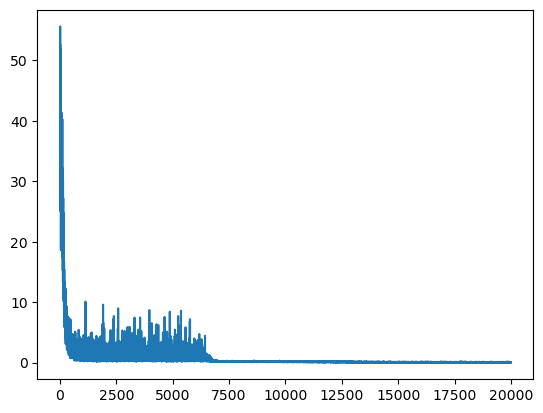

In [4]:
model.compile(optimizer=RMSprop(),metrics=['loss'])

x=tf.linspace(-5, 5, 100)
history = model.fit(x,epochs=20000,verbose=0)
plt.plot(history.history["loss"])

4/4 [==============================] - 0s 1ms/step


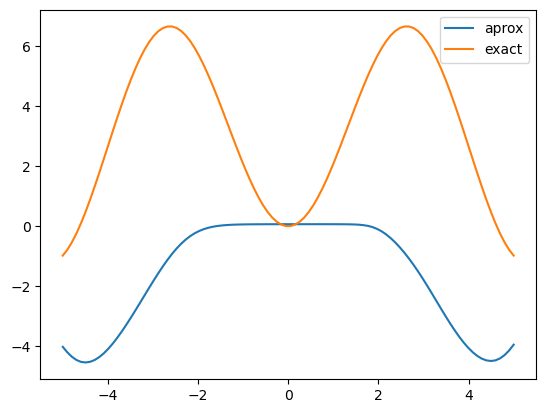

In [6]:
def sola(x):
    return ((x**2 - 2)*np.sin(x))/x - 2*np.cos(x) + 4

x_testv = tf.linspace(-5, 5,100)
a=model.predict(x_testv)
plt.plot(x_testv,a,label="aprox")
plt.plot(x_testv, sola(x_testv),label="exact")
plt.legend()
plt.show()